# NLP Model for flower detection

## Libraries and imports

In [1]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 28.9 MB/s 
     |████████████████████████████████| 596 kB 64.4 MB/s 
     |████████████████████████████████| 6.6 MB 61.4 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip3 install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=76a9dfd5fd4a110a371b58623a7260eb470ca19775e499488ea1cdd59aa7f144
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import string
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, RobertaTokenizer, RobertaModel
#from nltk.corpus import stopwords
from stop_words import get_stop_words

# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data and preproccess data

In [4]:
data = pd.read_csv('/content/sim&anno.csv')

In [5]:
data = data.iloc[: , 1:]

In [6]:
stop_words = get_stop_words('en')

def remove_stopWords(s):
    '''For removing stop words
    '''
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

In [7]:
import re 

#remove stopwords
data.loc[:,"sentence"] = data.sentence.apply(lambda x: remove_stopWords(x))
#lowercap
data.loc[:,"sentence"] = data.sentence.apply(lambda x : str.lower(x))
#remove all numbers
data['sentence'] = data['sentence'].apply(lambda x: re.sub(r'[0-9]+','',str(x)))
#remove punctuation
data['sentence'] = data['sentence'].replace(r'[^\w\s]+', '')
#remove \n
data['sentence'] = data['sentence'].replace('\n', '')
#remove nan mentions
data.drop(data.loc[data['sentence']=='nan'].index, inplace=True)
data.loc[:,"sentence"] = data.sentence.apply(lambda x: str.replace(x,'nan', ''))

In [8]:
from sklearn.model_selection import train_test_split

data = data.sample(frac=1).reset_index(drop=True)
train_flower, test_flower = train_test_split(data, test_size=0.1)

In [9]:
print(len(train_flower))
print(len(test_flower))

2795
311


In [10]:
train_dfflower = train_flower[['sentence', 'Flower Smell']]

# Split data

### Split

In [11]:
train_inds, val_inds = next(GroupShuffleSplit(test_size=.1, n_splits=2, random_state = 7).split(train_dfflower, groups=train_dfflower['sentence']))
#print(train_inds, val_inds)
train, val = train_dfflower.iloc[train_inds], train_dfflower.iloc[val_inds]


train_text = train['sentence']
train_labels = train['Flower Smell']
val_text = val['sentence']
val_labels = val['Flower Smell']
#print(train_text, train_labels)

### Visualisations

168


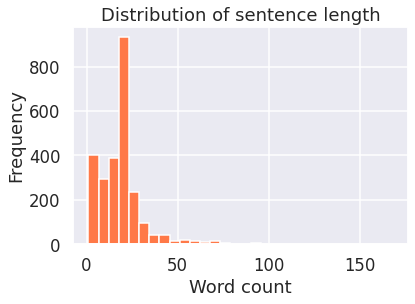

In [13]:
sns.set_theme()
#sns.set(rc={'figure.figsize':(9,6)})
# sns.set_style("white")
sns.set_context("talk")

seq_len = [len(i.split()) for i in train_text]
print(max(seq_len))
plt = pd.Series(seq_len).hist(bins = 30, color='#ff7948')


plt.set_title('Distribution of sentence length')
plt.set_xlabel('Word count')
plt.set_ylabel('Frequency')

plt.figure.savefig('dist.png')

Flower Smell
0    1402
1    1393
dtype: int64


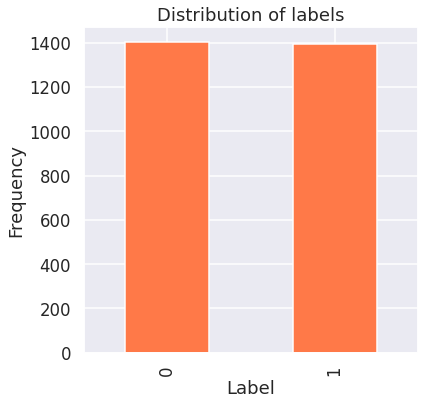

In [14]:
sns.set_theme()
sns.set(rc={'figure.figsize':(6,6)})
# sns.set_style("white")
sns.set_context("talk")

label_cnt = train_flower.groupby(['Flower Smell']).size()
print(label_cnt)

plt = label_cnt.plot.bar(color='#ff7948')


plt.set_title('Distribution of labels')
plt.set_xlabel('Label')
plt.set_ylabel('Frequency')

plt.figure.savefig('dist.png', bbox_inches="tight")

# Train Data

In [12]:
# import BERT-base pretrained model
#bert = AutoModel.from_pretrained('bert-large-uncased')

# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
bert = RobertaModel.from_pretrained('roberta-large')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 112, #256
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 112, #256
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [19]:
#freeze all the parameters
#for param in bert.parameters():
#    param.requires_grad = True

In [16]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(1024,512) #768 for base, 1024 for large
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [17]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [18]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-6)          # learning rate

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [19]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
#class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
#class_weights = dict(zip(np.unique(train_labels), class_weights))

print("Class Weights:",class_weights)

Class Weights: [0.99760956 1.00240192]


In [20]:
# converting list of class weights to a tensor
weights = torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 30

In [21]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [22]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [23]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 30
  Batch    50  of     79.

Evaluating...

Training Loss: 0.578
Validation Loss: 0.422

 Epoch 2 / 30
  Batch    50  of     79.

Evaluating...

Training Loss: 0.431
Validation Loss: 0.342

 Epoch 3 / 30
  Batch    50  of     79.

Evaluating...

Training Loss: 0.363
Validation Loss: 0.297

 Epoch 4 / 30
  Batch    50  of     79.

Evaluating...

Training Loss: 0.285
Validation Loss: 0.240

 Epoch 5 / 30
  Batch    50  of     79.

Evaluating...

Training Loss: 0.198
Validation Loss: 0.226

 Epoch 6 / 30
  Batch    50  of     79.

Evaluating...

Training Loss: 0.153
Validation Loss: 0.214

 Epoch 7 / 30
  Batch    50  of     79.

Evaluating...

Training Loss: 0.134
Validation Loss: 0.234

 Epoch 8 / 30
  Batch    50  of     79.

Evaluating...

Training Loss: 0.120
Validation Loss: 0.243

 Epoch 9 / 30
  Batch    50  of     79.

Evaluating...

Training Loss: 0.115
Validation Loss: 0.248

 Epoch 10 / 30
  Batch    50  of     79.

Evaluating...

Training Loss: 0.111
Validation L

# Test 

In [24]:
test_flower = test_flower[['sentence', 'Flower Smell']]

In [ ]:
#data = pd.read_csv('/content/test.csv')

In [25]:
#load weights of best model
path = '/content/saved_weights.pt'
# path = '../input/saved-model/saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [26]:
test_flower

,sentence,Flower Smell
2869,niffy anemonee popular way go see it. after al...,1
1389,odors polyanthus (graniticus spp.) (tolotlacti...,1
428,"it flowers beginning february middle april , p...",1
2208,or hot bitters,0
814,"funky violet, pink, pink, violet, pink.",1
...,...,...
12,used preparing confectio scammonii pilula aloe...,0
2491,"expeller catarhes , banisher agues , guts onel...",0
2391,"when oyl salt plants great proportion plant , ...",0
772,"colourless pale yellow recent , gradually beco...",0


In [27]:
test_text = test_flower['sentence']

In [28]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 112,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [29]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [30]:
torch.cuda.empty_cache()

In [31]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [32]:
results =[]

for pred in preds:
  if pred[0] > pred[1]:
    results.append(0)
  if pred[0] < pred[1]:
    results.append(1)


In [33]:
test_flower['pred_values'] = results

Flower Smell
0    157
1    154
dtype: int64


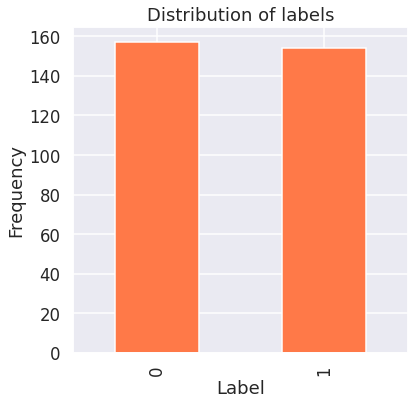

In [35]:
sns.set_theme()
sns.set(rc={'figure.figsize':(6,6)})
# sns.set_style("white")
sns.set_context("talk")

label_cnt = test_flower.groupby(['Flower Smell']).size()
print(label_cnt)

plt = label_cnt.plot.bar(color='#ff7948')


plt.set_title('Distribution of labels')
plt.set_xlabel('Label')
plt.set_ylabel('Frequency')

plt.figure.savefig('dist.png', bbox_inches="tight")

In [36]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
y_true = test_flower[['Flower Smell']]
y_pred = test_flower[['pred_values']]
precision_recall_fscore_support(y_true, y_pred, average='micro')

(0.9903536977491961, 0.9903536977491961, 0.9903536977491961, None)

In [37]:
print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))

Accuracy: 0.990


In [38]:
print('Specificity: %.3f' % recall_score(y_true, y_pred, pos_label=0))

Specificity: 0.994


In [39]:
import sklearn
from sklearn import metrics

sklearn.metrics.roc_curve(y_true, y_pred)

(array([0.        , 0.00636943, 1.        ]),
 array([0.        , 0.98701299, 1.        ]),
 array([2, 1, 0]))

In [40]:
from sklearn.metrics import roc_auc_score
print('ROCAUC score:',roc_auc_score(y_true, y_pred))
print('Accuracy score:',accuracy_score(y_true, y_pred))
print('F1 score:',f1_score(y_true, y_pred))

ROCAUC score: 0.9903217801306973
Accuracy score: 0.9903536977491961
F1 score: 0.990228013029316


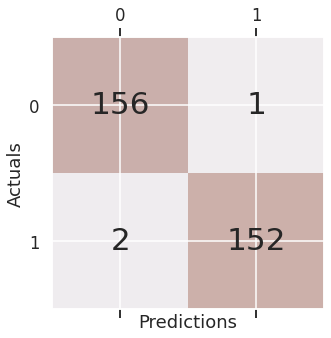

In [41]:
# Print the confusion matrix using Matplotlib

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
#plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [42]:
test_flower.to_csv("/content/test.csv", index = False)